## Condition classification

### Imports

In [89]:
# Core imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Model imports (baseline + advanced)
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Preprocessing & evaluation imports
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import optuna

# Interpretability imports
import shap
from alibi.explainers import ALE, plot_ale

In [90]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    matthews_corrcoef,
    balanced_accuracy_score
)
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import classification_report

from scipy.stats import randint, uniform

### Read

In [91]:
df = pd.read_csv('../data/cleaned/data_final.csv')

# Eliminar variables claramente no predictivas de texto libre
cols_to_drop = ["url", "description","new"]
cols_to_drop = [c for c in cols_to_drop if c in df.columns]
df = df.drop(columns=cols_to_drop)

df["condition"] = df["condition"].replace("Nuevo", "Buen estado")


# Variable objetivo
target_col = "condition"
y = df[target_col]
X = df.drop(columns=[target_col])

# Convertir object -> category
for col in X.select_dtypes(include="object").columns:
    X[col] = X[col].astype("category")

# Listas de variables numéricas y categóricas
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["bool", "category"]).columns.tolist()

print("Variables numéricas:", numeric_features)
print("Variables categóricas:", categorical_features)

Variables numéricas: ['price', 'built_area', 'usable_area', 'bedrooms', 'bathrooms', 'floor', 'year']
Variables categóricas: ['zone', 'neighborhood', 'exterior', 'elevator', 'garage', 'storage_room', 'balcony', 'agency', 'consumption_label', 'emissions_label']


### Models & scoring

In [92]:
# Multi-metric scoring for imbalance & multi-class quality
SCORING = {
    'accuracy': 'accuracy',
    'recall_weighted': 'recall_weighted',
    'precision_weighted': 'precision_weighted',
    'f1_weighted': 'f1_weighted',
    'f1_macro': 'f1_macro',        # Critical: reveals performance on minority classes
    'matthews': 'matthews_corrcoef',
    'balanced_accuracy': 'balanced_accuracy'
}

# Diverse baseline and advanced models
MODELS = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Random Forest (tuned)': RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_split=5, random_state=42, n_jobs=-1),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class='auto'),
    'Naive Bayes': GaussianNB(),
    #'SVM (Linear)': SVC(kernel='linear', random_state=42, probability=True),
    'SVM (RBF)': SVC(kernel='rbf', probability=True),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Hist Gradient Boosting': HistGradientBoostingClassifier(max_iter=100, random_state=42),
    'k-NN': KNeighborsClassifier(n_neighbors=5),
    'Hist Gradient Boosting': HistGradientBoostingClassifier(max_iter=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'CatBoost': CatBoostClassifier(iterations=100, random_state=42, verbose=0, allow_writing_files=False),
}

# Stratified CV preserves class distribution
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Train / Test split

In [93]:
# Train/Test Split - avoid data leakage
from sklearn.model_selection import train_test_split
RANDOM_STATE = 42

# Assume that `X_zone` and `y_zone` are already built in previous cells
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

### Evaluate function

In [94]:
def evaluate_models(X, y, cv_strategy=cv_strategy, scoring=SCORING, models=MODELS):
    """
    Valida en CV estratificada un diccionario de modelos.
    - Imprime métricas globales (accuracy, f1_macro, etc.) promedio +/- std.
    - Imprime, para cada modelo, un classification_report con métricas por clase
      (p.ej. 'A reformar', 'Buen estado', 'Nuevo') usando cross_val_predict.
    """
    results = {}

    # Por si queremos nombres de clases legibles (si y son strings, se usan tal cual)
    class_labels = np.unique(y)

    for name, model in models.items():
        print("\n" + "="*80)
        print(f"Modelo: {name}")
        print("="*80)

        # ------------------------------
        # 1) Métricas globales con cross_validate
        # ------------------------------
        scores = cross_validate(
            model,
            X,
            y,
            cv=cv_strategy,
            scoring=scoring,
            return_train_score=False,
            n_jobs=-1,
            error_score="raise"   # si algo peta, que lo veamos
        )

        results[name] = {"global": {}, "per_class": None}

        print("\nMÉTRICAS GLOBALES (media ± std en CV):")
        for metric_name, metric_scores in scores.items():
            if metric_name.startswith('test_'):
                metric = metric_name.replace('test_', '')
                mean_ = metric_scores.mean()
                std_  = metric_scores.std()
                results[name]["global"][metric] = (mean_, std_)
                print(f"  {metric:>18}: {mean_:.4f} (+/- {std_:.4f})")

        # ------------------------------
        # 2) Métricas por clase con cross_val_predict
        # ------------------------------
        print("\nMÉTRICAS POR CLASE (validación cruzada, cross_val_predict):")
        # cross_val_predict entrena/valida en cada fold y devuelve pred para cada muestra
        y_pred_cv = cross_val_predict(
            model,
            X,
            y,
            cv=cv_strategy,
            n_jobs=-1,
            method="predict"
        )

        # classification_report ya te da precisión, recall, f1 por clase
        report_dict = classification_report(
            y,
            y_pred_cv,
            labels=class_labels,
            target_names=[str(c) for c in class_labels],
            output_dict=True
        )
        # Guardamos el dict (por si luego quieres usarlo programáticamente)
        results[name]["per_class"] = report_dict

        # Imprimimos una versión legible
        print(classification_report(
            y,
            y_pred_cv,
            labels=class_labels,
            target_names=[str(c) for c in class_labels]
        ))

    return results

### Model evaluation

In [95]:
print("="*80)
print("Strategy 1: Use all variables; one-hot encode ALL categorical features")
print("="*80)

cat_cols1 = X_train_raw.select_dtypes(include=["object", "category"]).columns.tolist()
# Si no quieres codificar el target, asegúrate de no incluir y:
# cat_cols1 = [c for c in cat_cols1 if c != "zone" y no es la target]

X_zone_encoded_1 = pd.get_dummies(X_train_raw, columns=cat_cols1)

X_zone_encoded_1.columns = [
    "".join(c if c.isalnum() else "_" for c in str(x))
    for x in X_zone_encoded_1.columns
]

y_zone_encoded_1 = LabelEncoder().fit_transform(y_train_raw)

print(f"\nSamples: {len(X_zone_encoded_1)}")
print(f"Features: {X_zone_encoded_1.shape[1]}")
print(f"Class distribution: {np.bincount(y_zone_encoded_1)}")

result1 = evaluate_models(X_zone_encoded_1, y_zone_encoded_1, models=MODELS, cv_strategy=cv_strategy)


Strategy 1: Use all variables; one-hot encode ALL categorical features

Samples: 983
Features: 381
Class distribution: [230 753]

Modelo: Random Forest

MÉTRICAS GLOBALES (media ± std en CV):
            accuracy: 0.7904 (+/- 0.0174)
     recall_weighted: 0.7904 (+/- 0.0174)
  precision_weighted: 0.7669 (+/- 0.0257)
         f1_weighted: 0.7581 (+/- 0.0187)
            f1_macro: 0.6264 (+/- 0.0290)
            matthews: 0.3101 (+/- 0.0624)
   balanced_accuracy: 0.6111 (+/- 0.0226)

MÉTRICAS POR CLASE (validación cruzada, cross_val_predict):
              precision    recall  f1-score   support

           0       0.62      0.27      0.38       230
           1       0.81      0.95      0.87       753

    accuracy                           0.79       983
   macro avg       0.71      0.61      0.63       983
weighted avg       0.77      0.79      0.76       983


Modelo: Random Forest (tuned)

MÉTRICAS GLOBALES (media ± std en CV):
            accuracy: 0.7762 (+/- 0.0064)
     recall_w

C:\Users\xabier.villa\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\xabier.villa\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\xabier.villa\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\xabier.villa\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set t

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       230
           1       0.77      1.00      0.87       753

    accuracy                           0.77       983
   macro avg       0.38      0.50      0.43       983
weighted avg       0.59      0.77      0.66       983


Modelo: Gradient Boosting

MÉTRICAS GLOBALES (media ± std en CV):
            accuracy: 0.7670 (+/- 0.0128)
     recall_weighted: 0.7670 (+/- 0.0128)
  precision_weighted: 0.7253 (+/- 0.0237)
         f1_weighted: 0.7225 (+/- 0.0145)
            f1_macro: 0.5646 (+/- 0.0236)
            matthews: 0.1959 (+/- 0.0531)
   balanced_accuracy: 0.5641 (+/- 0.0176)

MÉTRICAS POR CLASE (validación cruzada, cross_val_predict):
              precision    recall  f1-score   support

           0       0.51      0.18      0.27       230
           1       0.79      0.95      0.86       753

    accuracy                           0.77       983
   macro avg       0.65      0.56

In [96]:
# Models that natively handle categorical features
MODELS_NATIVE = {
    'XGBoost': XGBClassifier(
        n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1,
        tree_method="hist", enable_categorical=True, use_label_encoder=False, eval_metric='mlogloss'
    ),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1),
    'CatBoost': CatBoostClassifier(iterations=100, random_state=42, verbose=0, allow_writing_files=False,
        cat_features=cat_cols1),
}

print("="*80)
print("Strategy 1.1: Use all variables with native categorical support (no one-hot)")
print("="*80)

X_zone_unencoded_1 = X_train_raw.copy()
# Clean column names (avoid special chars)
X_zone_unencoded_1.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_zone_unencoded_1.columns]
y_zone_unencoded_1 = LabelEncoder().fit_transform(y_train_raw)

print(f"\nSamples: {len(X_zone_unencoded_1)}")
print(f"Features: {X_zone_unencoded_1.shape[1]}")
print(f"Class distribution: {np.bincount(y_zone_unencoded_1)}")

result11 = evaluate_models(X_zone_unencoded_1, y_zone_unencoded_1, models=MODELS_NATIVE, scoring=SCORING)
print("\n" + "="*80)

Strategy 1.1: Use all variables with native categorical support (no one-hot)

Samples: 983
Features: 17
Class distribution: [230 753]

Modelo: XGBoost

MÉTRICAS GLOBALES (media ± std en CV):
            accuracy: 0.7661 (+/- 0.0427)
     recall_weighted: 0.7661 (+/- 0.0427)
  precision_weighted: 0.7434 (+/- 0.0451)
         f1_weighted: 0.7478 (+/- 0.0409)
            f1_macro: 0.6263 (+/- 0.0559)
            matthews: 0.2720 (+/- 0.1198)
   balanced_accuracy: 0.6133 (+/- 0.0487)

MÉTRICAS POR CLASE (validación cruzada, cross_val_predict):
              precision    recall  f1-score   support

           0       0.50      0.33      0.39       230
           1       0.81      0.90      0.85       753

    accuracy                           0.77       983
   macro avg       0.66      0.61      0.62       983
weighted avg       0.74      0.77      0.75       983


Modelo: LightGBM

MÉTRICAS GLOBALES (media ± std en CV):
            accuracy: 0.7579 (+/- 0.0303)
     recall_weighted: 0.757

### Model evaluation with class weight adjustemnt

In [97]:
# Test multiple models with class_weight adjustments where supported
class_weight = {0: 5.0, 1: 1.0}

MODELS_BALANCED = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight),
    'Random Forest (tuned)': RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_split=5, random_state=42, n_jobs=-1, class_weight=class_weight),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial', class_weight=class_weight),
    'Naive Bayes': GaussianNB(),
    # 'SVM (Linear)': SVC(kernel='linear', random_state=42, probability=True),
    'SVM (RBF)': SVC(kernel='rbf', probability=True, class_weight=class_weight),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),# no balance
    'Hist Gradient Boosting': HistGradientBoostingClassifier(max_iter=100, random_state=42, class_weight=class_weight),
    'k-NN': KNeighborsClassifier(n_neighbors=5),# no balance
    'Hist Gradient Boosting': HistGradientBoostingClassifier(max_iter=100, random_state=42, class_weight=class_weight),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1, class_weight=class_weight),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight=class_weight),
    'CatBoost': CatBoostClassifier(iterations=100, random_state=42, verbose=0, allow_writing_files=False),
}

print("="*80)
print("Strategy 1.3: Evaluate models with class_weight given more weight to minority class ('A reformar')")
print("="*80)

print(f"\nSamples: {len(X_zone_encoded_1)}")
print(f"Features: {X_zone_encoded_1.shape[1]}")
print(f"Class distribution: {np.bincount(y_zone_encoded_1)}")

result13 = evaluate_models(X_zone_encoded_1, y_zone_encoded_1, models=MODELS_BALANCED, cv_strategy=cv_strategy)

print("\n" + "="*80)

Strategy 1.3: Evaluate models with class_weight given more weight to minority class ('A reformar')

Samples: 983
Features: 381
Class distribution: [230 753]

Modelo: Random Forest

MÉTRICAS GLOBALES (media ± std en CV):
            accuracy: 0.8016 (+/- 0.0224)
     recall_weighted: 0.8016 (+/- 0.0224)
  precision_weighted: 0.7850 (+/- 0.0277)
         f1_weighted: 0.7755 (+/- 0.0215)
            f1_macro: 0.6572 (+/- 0.0308)
            matthews: 0.3638 (+/- 0.0682)
   balanced_accuracy: 0.6365 (+/- 0.0245)

MÉTRICAS POR CLASE (validación cruzada, cross_val_predict):
              precision    recall  f1-score   support

           0       0.65      0.33      0.43       230
           1       0.82      0.95      0.88       753

    accuracy                           0.80       983
   macro avg       0.74      0.64      0.66       983
weighted avg       0.78      0.80      0.78       983


Modelo: Random Forest (tuned)

MÉTRICAS GLOBALES (media ± std en CV):
            accuracy: 0.700

### LGBM Optimization

In [98]:
class_weight = {0: 5.0, 1: 1.0}
def objective(trial):
    # Optuna search space tuned for small, imbalanced dataset
    param = {
        'objective': 'binary',         
        'metric': 'binary_logloss', 
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'class_weight': class_weight,
        'n_jobs': -1,
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 15, 60),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 30),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'subsample_freq': 1
    }
    model = LGBMClassifier(**param)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_zone_unencoded_1, y_zone_unencoded_1, cv=cv, scoring='f1_macro', n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize', study_name="LGBM_Optimization")
print("Running Optuna optimization (50 trials)...")
study.optimize(objective, n_trials=50)

print("\n------------------------------------------------")
print(f"Best Macro F1 (Optuna): {study.best_value:.4f}")
print("------------------------------------------------")
print("Best Params (Optuna):")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-12-02 12:52:30,739] A new study created in memory with name: LGBM_Optimization


Running Optuna optimization (50 trials)...


[I 2025-12-02 12:52:31,204] Trial 0 finished with value: 0.6059437978925819 and parameters: {'n_estimators': 173, 'learning_rate': 0.016014781320220415, 'num_leaves': 46, 'max_depth': 3, 'min_child_samples': 6, 'reg_alpha': 0.16159145494092617, 'reg_lambda': 0.011564199827457416, 'colsample_bytree': 0.532946379144307, 'subsample': 0.7763894010438573}. Best is trial 0 with value: 0.6059437978925819.
[I 2025-12-02 12:52:33,987] Trial 1 finished with value: 0.666109020083504 and parameters: {'n_estimators': 415, 'learning_rate': 0.029355635462455582, 'num_leaves': 24, 'max_depth': 12, 'min_child_samples': 7, 'reg_alpha': 0.07723017778060828, 'reg_lambda': 0.004527649664713642, 'colsample_bytree': 0.8953121172842142, 'subsample': 0.5775717562734718}. Best is trial 1 with value: 0.666109020083504.
[I 2025-12-02 12:52:35,660] Trial 2 finished with value: 0.6450366425278551 and parameters: {'n_estimators': 434, 'learning_rate': 0.03286233781764888, 'num_leaves': 45, 'max_depth': 8, 'min_child


------------------------------------------------
Best Macro F1 (Optuna): 0.6844
------------------------------------------------
Best Params (Optuna):
  n_estimators: 354
  learning_rate: 0.02316091375852571
  num_leaves: 35
  max_depth: 7
  min_child_samples: 16
  reg_alpha: 0.03812828486298774
  reg_lambda: 1.663697690965518
  colsample_bytree: 0.7412766800697541
  subsample: 0.7138399270817808


Detected condition categories:
['A reformar' 'Buen estado']

--- Detailed Classification Report ---
              precision    recall  f1-score   support

  A reformar       0.46      0.58      0.51        57
 Buen estado       0.86      0.79      0.83       189

    accuracy                           0.74       246
   macro avg       0.66      0.69      0.67       246
weighted avg       0.77      0.74      0.75       246


--- Normalized Confusion Matrix ---


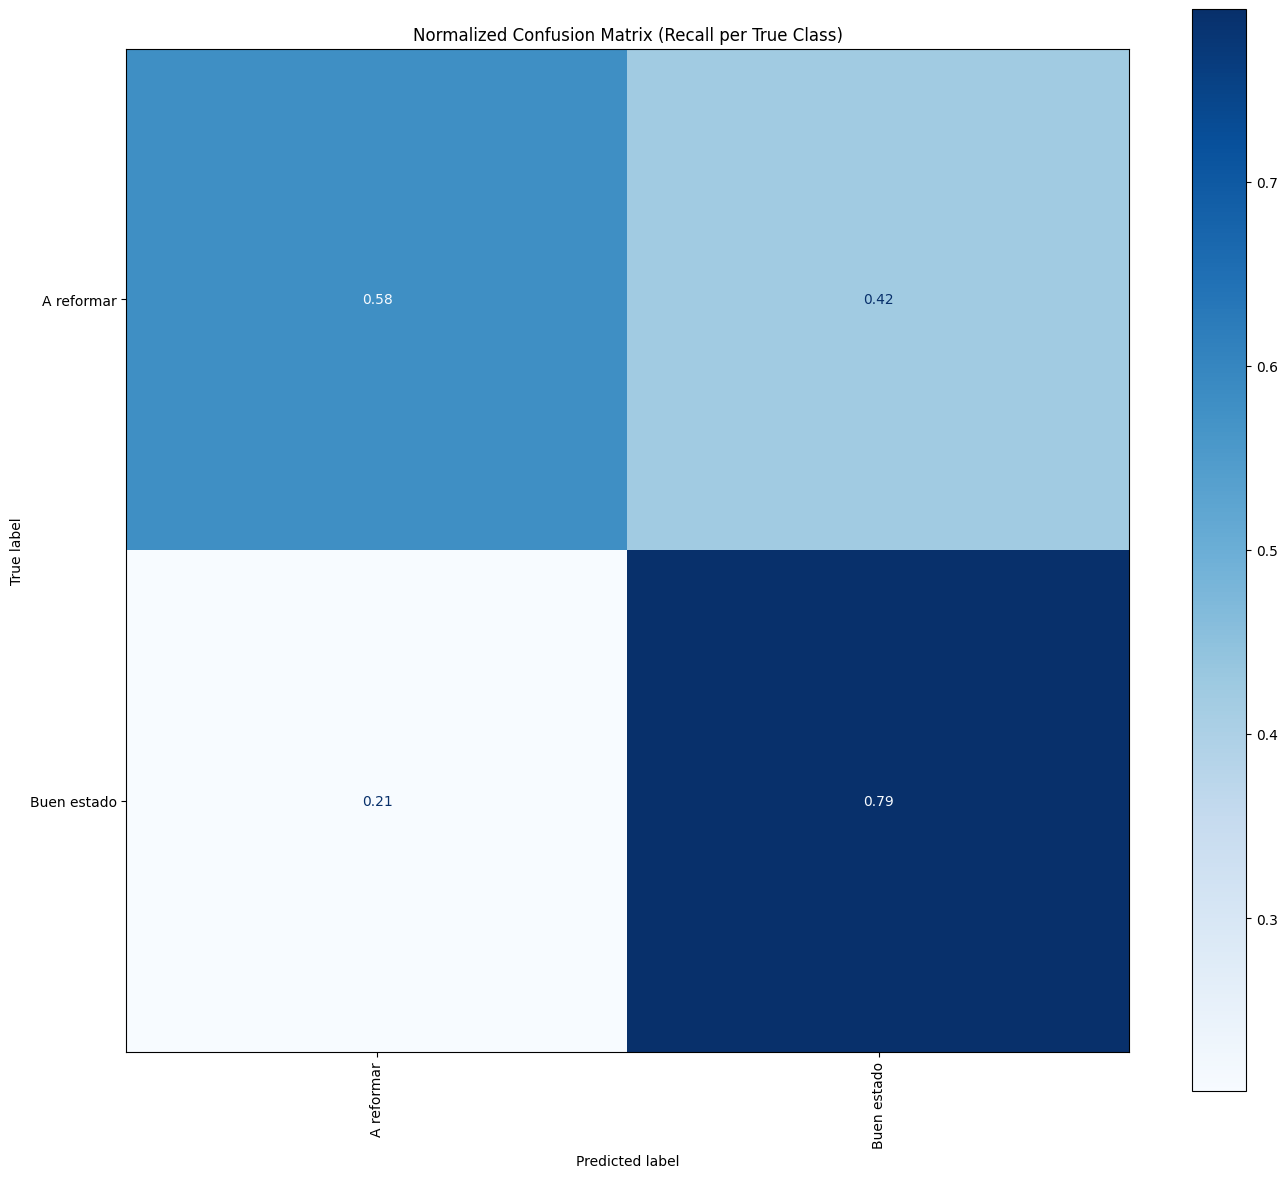

In [99]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

# Temporary encoder for original text condition labels
le_temp = LabelEncoder()
le_temp.fit(y)
class_names = le_temp.classes_

print("Detected condition categories:")
print(class_names)

# Retrieve best Optuna params
best_params = study.best_params
# Add fixed params

best_params['random_state'] = 42
best_params['class_weight'] = {
    'A reformar': 5.0,    # más importancia
    'Buen estado': 1.0    # referencia
}
best_params['objective'] = 'binary'
best_params['n_jobs'] = -1


# Train initial final model
final_model = LGBMClassifier(**best_params)
final_model.fit(X_train_raw, y_train_raw)

# Predict
y_pred = final_model.predict(X_test_raw)

# Classification report
print("\n--- Detailed Classification Report ---")
print(classification_report(y_test_raw, y_pred, target_names=class_names))
# Confusion matrix (normalized)
print("\n--- Normalized Confusion Matrix ---")
fig, ax = plt.subplots(figsize=(14, 12))
ConfusionMatrixDisplay.from_predictions(
    y_test_raw, y_pred,
    ax=ax,
    display_labels=class_names,
    xticks_rotation='vertical',
    cmap='Blues',
    normalize='true',
    values_format=".2f"
)
plt.title("Normalized Confusion Matrix (Recall per True Class)")
plt.tight_layout()
plt.show()

### Feature Engineering price_m2

Variable price_m2 created in Train and Test.
Training model with price_m2 feature...

--- Classification Report (with price_m2) ---
              precision    recall  f1-score   support

  A reformar       0.50      0.56      0.53        57
 Buen estado       0.86      0.83      0.85       189

    accuracy                           0.77       246
   macro avg       0.68      0.70      0.69       246
weighted avg       0.78      0.77      0.77       246


--- Top 10 Features (with price_m2) ---
         Feature  Importance
17      price_m2        1869
4    usable_area        1301
13          year        1266
0          price        1176
3     built_area        1129
7          floor         652
5       bedrooms         403
2   neighborhood         379
6      bathrooms         187
14        agency         156


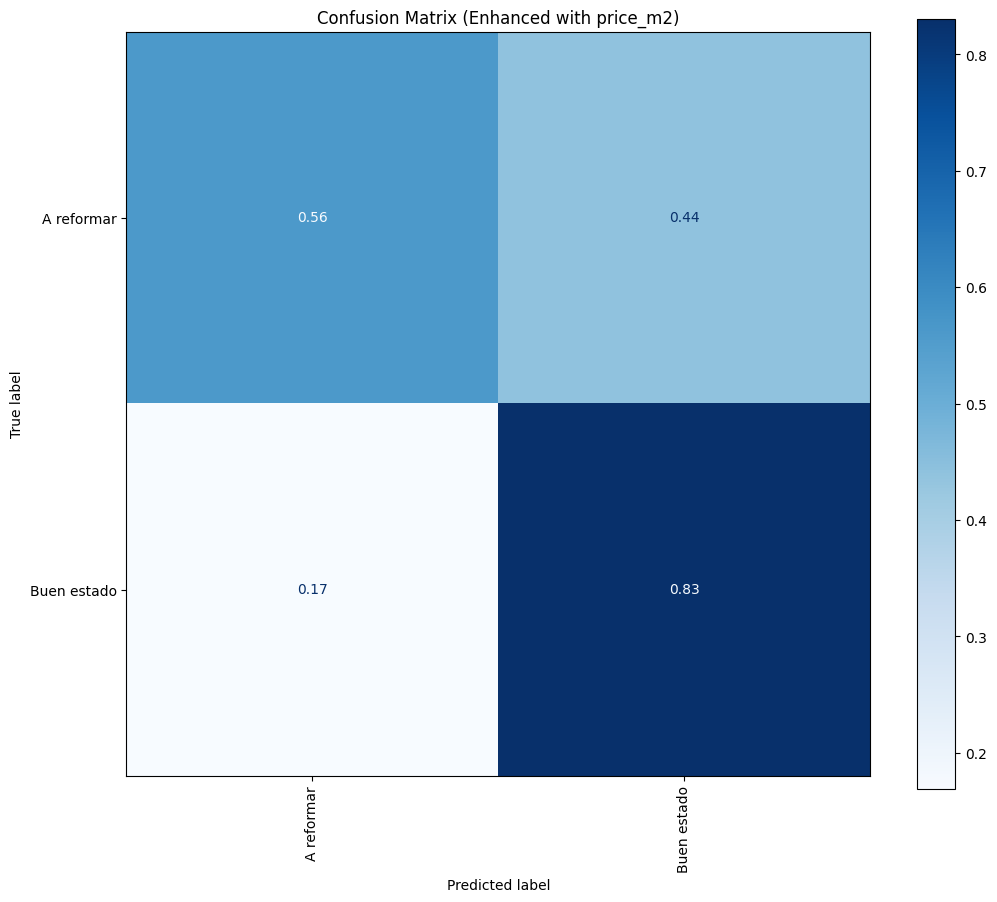

In [100]:
# 1. Apply Feature Engineering to the ORIGINAL DataFrames
X_train_raw['price_m2'] = X_train_raw['price'] / X_train_raw['usable_area']
X_test_raw['price_m2'] = X_test_raw['price'] / X_test_raw['usable_area'] # Vital for the final predict!

# Update the copy for Optuna
X_zone_unencoded_1 = X_train_raw.copy()

print(f"Variable price_m2 created in Train and Test.")


# Re-train with previously found best parameters (before new Optuna run)
final_model_m2 = LGBMClassifier(**best_params)
print("Training model with price_m2 feature...")
final_model_m2.fit(X_train_raw, y_train_raw)

y_pred_m2 = final_model_m2.predict(X_test_raw)

print("\n--- Classification Report (with price_m2) ---")
print(classification_report(y_test_raw, y_pred_m2, target_names=class_names))

# Feature importance (top 10)
importances = final_model_m2.feature_importances_
df_imp = pd.DataFrame({'Feature': X_train_raw.columns, 'Importance': importances})
df_imp = df_imp.sort_values(by='Importance', ascending=False).head(10)
print("\n--- Top 10 Features (with price_m2) ---")
print(df_imp)

# Normalized confusion matrix for comparison
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test_raw, y_pred_m2,
    ax=ax,
    display_labels=class_names,
    xticks_rotation='vertical',
    cmap='Blues',
    normalize='true',
    values_format=".2f"
)
plt.title("Confusion Matrix (Enhanced with price_m2)")
plt.show()

In [101]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_zone_unencoded_1 = le.fit_transform(y_train_raw)  # ya lo estabas haciendo parecido

print(le.classes_)   # te mostrará: ['A reformar' 'Buen estado' 'Nuevo'] (esperado)

idx_ar = list(le.classes_).index("A reformar")  # normalmente será 0
print("Índice de 'A reformar':", idx_ar)


['A reformar' 'Buen estado']
Índice de 'A reformar': 0


In [102]:
import optuna
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from lightgbm import LGBMClassifier

# --- scorer que da más peso a "A reformar" (clase idx_ar) ---
def f1_custom_ar(y_true, y_pred):
    # average=None → devuelve f1 por clase en un array [clase0, clase1]
    f1_per_class = f1_score(y_true, y_pred, average=None)

    f1_ar   = f1_per_class[idx_ar]  # "A reformar"
    f1_buen = f1_per_class[1 - idx_ar]  # la otra clase

    # Ponderación: 0.6 para "A reformar", 0.4 para "Buen estado"
    return 0.7 * f1_ar + 0.3 * f1_buen

scorer_f1_custom_ar = make_scorer(f1_custom_ar)

def objective(trial):
    # <<< AQUÍ TUNEAMOS EL PESO DE "A reformar" >>>
    weight_ar = trial.suggest_float('weight_ar', 1.0, 10.0)
    class_weight = {
        idx_ar: weight_ar,        # más peso a "A reformar"
        1 - idx_ar: 1.0           # referencia para "Buen estado"
    }

    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'class_weight': class_weight,
        'n_jobs': -1,
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 30),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 5.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 5.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'subsample_freq': 1
    }

    model = LGBMClassifier(**param)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scores = cross_val_score(
        model,
        X_zone_unencoded_1,  # tus features
        y_zone_unencoded_1,  # tus etiquetas codificadas (0/1)
        cv=cv,
        scoring=scorer_f1_custom_ar,
        n_jobs=-1
    )
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best custom F1 (más peso a 'A reformar'):", study.best_value)
print("Best params:", study.best_params)


[I 2025-12-02 12:54:26,015] A new study created in memory with name: no-name-960d8e7c-5eed-4b15-a69b-fc3d1979e5f6
[I 2025-12-02 12:54:28,111] Trial 0 finished with value: 0.6048415156200497 and parameters: {'weight_ar': 5.179204403275946, 'n_estimators': 562, 'learning_rate': 0.07808165128380087, 'num_leaves': 22, 'max_depth': 11, 'min_child_samples': 17, 'reg_alpha': 2.845974123366055, 'reg_lambda': 0.5047676154673704, 'colsample_bytree': 0.7691928947384306, 'subsample': 0.7927373339451229}. Best is trial 0 with value: 0.6048415156200497.
[I 2025-12-02 12:54:30,603] Trial 1 finished with value: 0.5911601047067643 and parameters: {'weight_ar': 5.28278822658174, 'n_estimators': 322, 'learning_rate': 0.10497999008504927, 'num_leaves': 35, 'max_depth': 15, 'min_child_samples': 14, 'reg_alpha': 0.025733053293651446, 'reg_lambda': 0.20281236906278766, 'colsample_bytree': 0.8900888222700403, 'subsample': 0.811755387508918}. Best is trial 0 with value: 0.6048415156200497.
[I 2025-12-02 12:54:

Best custom F1 (más peso a 'A reformar'): 0.6215196010459
Best params: {'weight_ar': 9.826726090673544, 'n_estimators': 203, 'learning_rate': 0.03398535934999778, 'num_leaves': 39, 'max_depth': 7, 'min_child_samples': 23, 'reg_alpha': 0.16321953421547014, 'reg_lambda': 0.0010254711948248568, 'colsample_bytree': 0.8603770509026804, 'subsample': 0.7397184577555472}


In [103]:
# Re-optimize after adding price_m2

def objective(trial):

        # <<< AQUÍ TUNEAMOS EL PESO DE "A reformar" >>>
    weight_ar = trial.suggest_float('weight_ar', 1.0, 10.0)
    class_weight = {
        idx_ar: weight_ar,        # más peso a "A reformar"
        1 - idx_ar: 1.0           # referencia para "Buen estado"
    }
    param = {
        'objective': 'binary',         
        'metric': 'binary_logloss', 
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'class_weight': class_weight,
        'n_jobs': -1,
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 30),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 5.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 5.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'subsample_freq': 1
    }
    model = LGBMClassifier(**param)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_zone_unencoded_1, y_zone_unencoded_1, cv=cv, scoring='f1_macro', n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize')
print("Re-optimizing with engineered feature price_m2 (50 trials)...")
study.optimize(objective, n_trials=50)

print(f"Final Best Macro F1 with price_m2: {study.best_value:.4f}")

[I 2025-12-02 12:56:29,742] A new study created in memory with name: no-name-4313144f-0b67-4c82-87ee-73bea6cad510


Re-optimizing with engineered feature price_m2 (50 trials)...


[I 2025-12-02 12:56:38,622] Trial 0 finished with value: 0.6448046131469212 and parameters: {'weight_ar': 2.501740338585167, 'n_estimators': 689, 'learning_rate': 0.011276611974162151, 'num_leaves': 55, 'max_depth': 7, 'min_child_samples': 12, 'reg_alpha': 0.0071659708236477635, 'reg_lambda': 0.002252236844921455, 'colsample_bytree': 0.9296712813102629, 'subsample': 0.9585068704963913}. Best is trial 0 with value: 0.6448046131469212.
[I 2025-12-02 12:56:41,483] Trial 1 finished with value: 0.6671459540370585 and parameters: {'weight_ar': 4.1207511067037625, 'n_estimators': 291, 'learning_rate': 0.0841562303800774, 'num_leaves': 52, 'max_depth': 9, 'min_child_samples': 30, 'reg_alpha': 0.05372907765939792, 'reg_lambda': 0.02615958851797731, 'colsample_bytree': 0.7804000171851873, 'subsample': 0.9864370571099371}. Best is trial 1 with value: 0.6671459540370585.
[I 2025-12-02 12:56:53,663] Trial 2 finished with value: 0.6579454328918853 and parameters: {'weight_ar': 4.295777655270179, 'n_

Final Best Macro F1 with price_m2: 0.6776


In [104]:
# Visualization of optimization trajectory & parameter importance
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

Training champion LightGBM model...

--- Final Classification Report ---
              precision    recall  f1-score   support

  A reformar       0.61      0.53      0.57        57
 Buen estado       0.86      0.90      0.88       189

    accuracy                           0.81       246
   macro avg       0.74      0.71      0.72       246
weighted avg       0.80      0.81      0.81       246


--- Final Normalized Confusion Matrix ---


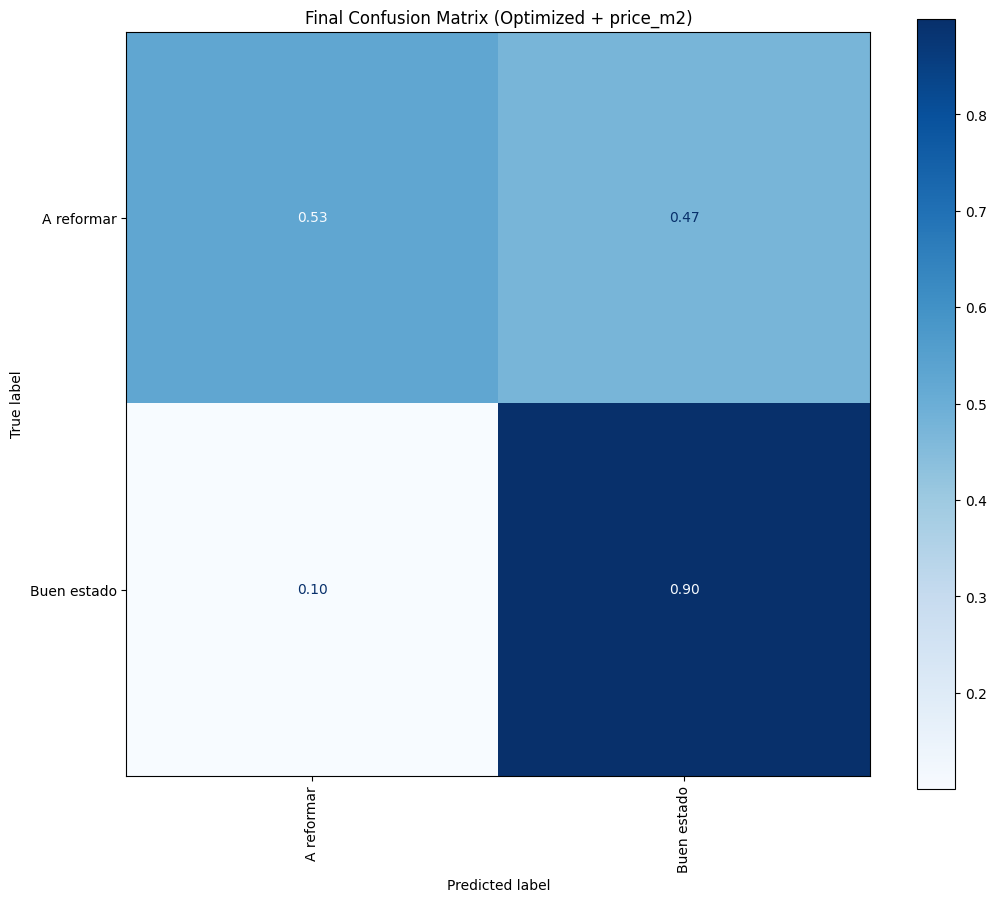

C:\Users\xabier.villa\AppData\Local\Temp\ipykernel_8272\1325427219.py:38: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




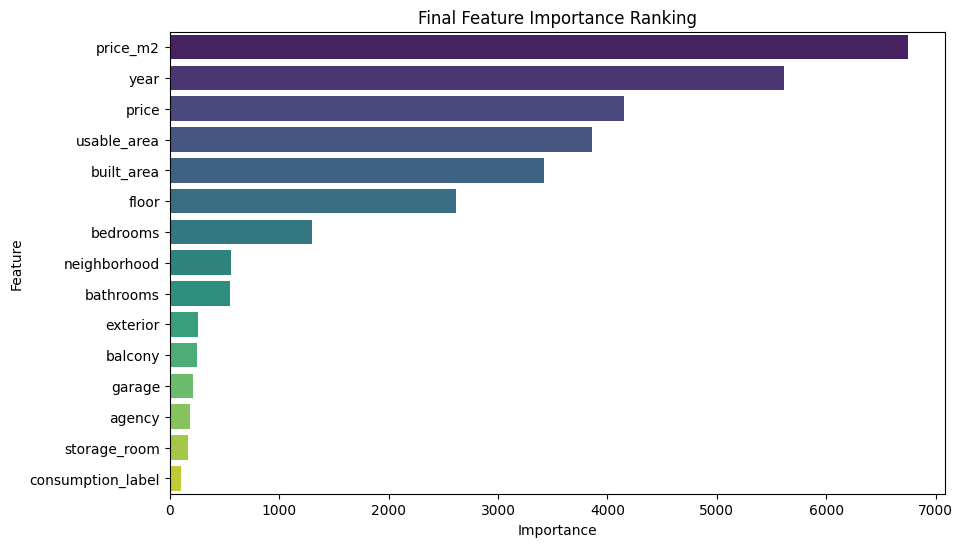

In [105]:
# Champion model parameters from latest Optuna run
best_params = study.best_params

# Add fixed parameters
best_params['random_state'] = 42
best_params['class_weight'] = 'balanced'
best_params['objective'] = 'binary'
best_params['n_jobs'] = -1
best_params['verbose'] = -1

print("Training champion LightGBM model...")
final_model = LGBMClassifier(**best_params)
final_model.fit(X_train_raw, y_train_raw)
y_pred = final_model.predict(X_test_raw)

print("\n--- Final Classification Report ---")
print(classification_report(y_test_raw, y_pred, target_names=class_names))
print("\n--- Final Normalized Confusion Matrix ---")
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test_raw, y_pred,
    ax=ax,
    display_labels=class_names,
    xticks_rotation='vertical',
    cmap='Blues',
    normalize='true',
    values_format=".2f"
)
plt.title("Final Confusion Matrix (Optimized + price_m2)")
plt.show()

# Feature importance ranking
importances = final_model.feature_importances_
df_imp = pd.DataFrame({'Feature': X_train_raw.columns, 'Importance': importances})
df_imp = df_imp.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_imp, x='Importance', y='Feature', palette='viridis')
plt.title('Final Feature Importance Ranking')
plt.show()

## Interpretation

In [106]:
# Select a subset of features to visualize ALE in a readable way
# Use model importances to prioritize
num_cols = list(X_train_raw.select_dtypes(include=[np.number]).columns)
importances = final_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': X_train_raw.columns, 'importance': importances})
feat_imp_df = feat_imp_df[feat_imp_df['feature'].isin(num_cols)]

# Top 4 most important numeric features
top_features = feat_imp_df.sort_values('importance', ascending=False)['feature'].head(4).tolist()
print('Top features for ALE:', top_features)

Top features for ALE: ['price_m2', 'year', 'price', 'usable_area']


In [107]:
# 1. Identify columns
categorical_cols = X_train_raw.select_dtypes(include=['category', 'object', 'bool']).columns.tolist()
numeric_cols = X_train_raw.select_dtypes(include=['number']).columns.tolist()
all_cols = X_train_raw.columns.tolist()

# 2. Save the EXACT data types from training
# This is what solves your error. We save the "memory" of the categories.
train_dtypes = X_train_raw.dtypes.to_dict()

# 3. Train the Encoder
encoder = OrdinalEncoder()
# Convert to string to avoid issues with nulls/mixed types
X_train_str = X_train_raw.copy()
for col in categorical_cols:
    X_train_str[col] = X_train_str[col].astype(str)
    
encoder.fit(X_train_str[categorical_cols])

# 4. Prepare numeric data for ALE
X_train_num = X_train_raw.copy()
X_train_num[categorical_cols] = encoder.transform(X_train_str[categorical_cols])
X_train_numpy = X_train_num.values

# 5. DEFINE THE CORRECTED WRAPPER
def predictor_wrapper(X_ndarray):
    # A. Reconstruct basic DataFrame
    df_temp = pd.DataFrame(X_ndarray, columns=all_cols)
    
    # B. Ensure numeric columns are float
    for col in numeric_cols:
        df_temp[col] = df_temp[col].astype(float)

    # C. Decode categoricals
    if len(categorical_cols) > 0:
        # Round and clip to avoid invalid indices generated by ALE
        cat_data = df_temp[categorical_cols].values.round().astype(int)
        for i, col in enumerate(categorical_cols):
            max_val = len(encoder.categories_[i]) - 1
            cat_data[:, i] = np.clip(cat_data[:, i], 0, max_val)
            
        # Convert back to text
        decoded_data = encoder.inverse_transform(cat_data)
        
        # D. ASSIGN THE EXACT TYPES FROM TRAINING
        # Here's the fix: Use the original dtype, not a new generic one
        for i, col in enumerate(categorical_cols):
            # First assign the values
            df_temp[col] = decoded_data[:, i]
            # Then force the original data type (which contains the complete list of categories)
            df_temp[col] = df_temp[col].astype(train_dtypes[col])

    # E. Predict
    return final_model.predict_proba(df_temp)

# 6. Initialize and Execute ALE
print("Initializing ALE with type correction...")
ale_explainer = ALE(predictor_wrapper, feature_names=all_cols, target_names=class_names)

print("Calculating explanations (patience)...")
final_model_exp = ale_explainer.explain(X_train_numpy)

print("Success! Plots ready.")

Initializing ALE with type correction...
Calculating explanations (patience)...
Success! Plots ready.


In [108]:
import matplotlib.pyplot as plt
import numpy as np

def comparar_barrios(feature, barrio1, barrio2, explanation_object, color1='blue', color2='orange'):
    """
    Grafica curvas ALE para dos barrios ignorando la línea horizontal de referencia.
    """
    try:
        idx1 = list(class_names).index(barrio1)
        idx2 = list(class_names).index(barrio2)
        
        print(f"Comparando {feature}: {barrio1} vs {barrio2}")
        
        fig, ax = plt.subplots(figsize=(8, 5))
        
        # We plot
        plot_ale(explanation_object, 
                 features=[feature], 
                 targets=[idx1, idx2],
                 n_cols=1, 
                 sharey=True,
                 ax=ax)

        # Get all the lines drawn
        lines = ax.get_lines()
        
        # Filter: We only want the lines that are NOT the flat line at 0
        # The logic is: if the maximum absolute Y value is almost 0, it's the reference line.
        data_lines = [line for line in lines if np.max(np.abs(line.get_ydata())) > 0.0001]

        # Now we color only the found data lines
        colores_a_usar = [color1, color2]
        
        for i, line in enumerate(data_lines):
            if i < len(colores_a_usar): # Avoid errors if there are more lines than expected
                line.set_color(colores_a_usar[i])
                line.set_linewidth(2.5) 
                line.set_alpha(0.8)
                
        # Ensure the reference line (the one left over) is a discreet gray
        for line in lines:
            if line not in data_lines:
                line.set_color('gray')
                line.set_linestyle('--')
                line.set_alpha(0.5)

        plt.title(f"Effect of '{feature}' on probability")
        # We manually force the legend to ensure the colors match the names
        from matplotlib.lines import Line2D
        custom_lines = [Line2D([0], [0], color=color1, lw=2.5),
                        Line2D([0], [0], color=color2, lw=2.5)]
        plt.legend(custom_lines, [barrio1, barrio2], loc='best')
        
        plt.grid(True, alpha=0.3)
        plt.show()
        
    except ValueError as e:
        print(f"Error: No se encontró el barrio. Revisa los nombres: {e}")
    except Exception as e:
        print(f"Error inesperado: {e}")

Comparando price_m2: A reformar vs Buen estado


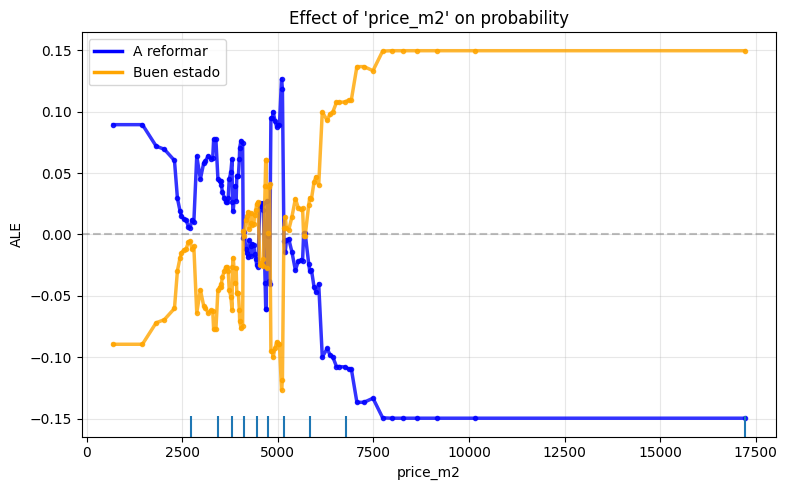

Comparando year: A reformar vs Buen estado


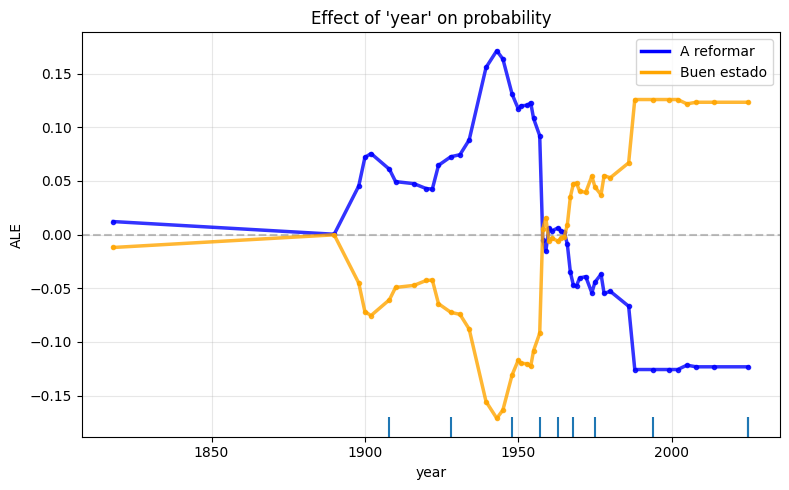

In [109]:
# A. THE EXTREME CONTRAST (To validate that the model makes sense)
# Abando (Most expensive zone) vs Otxarkoaga (Most affordable zone)
comparar_barrios('price_m2', 'A reformar', 'Buen estado', final_model_exp)

# B. THE CONFUSION (Indautxu vs Abando)
# Both lines rise together because both are expensive zones.
comparar_barrios('year', 'A reformar', 'Buen estado', final_model_exp)

SHAP

In [110]:
# Code for SHAP Values
# Create the explainer with the LightGBM model
explainer = shap.TreeExplainer(final_model)

# Calculate SHAP values on the test set (Explanation)
shap_values = explainer(X_test_raw)

--- SHAP ANALYSIS: BUEN ESTADO (clase positiva) ---


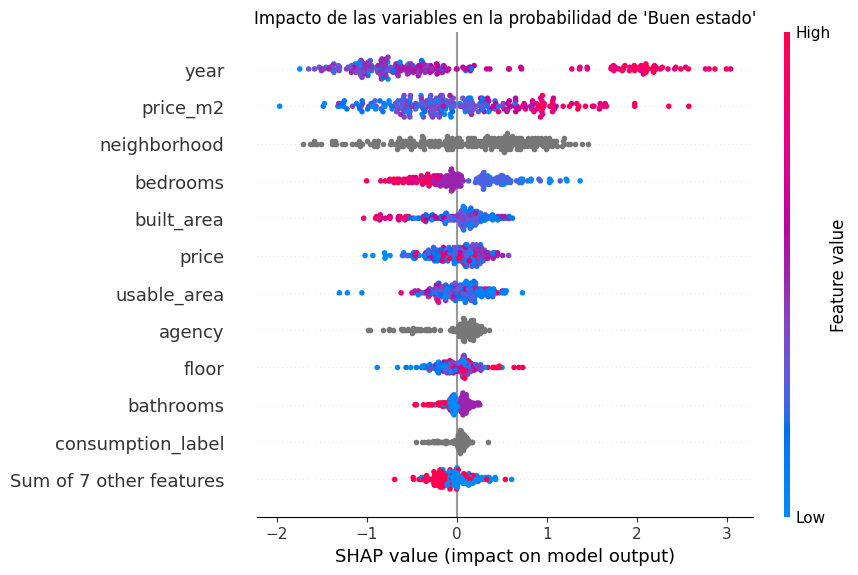


--- SHAP ANALYSIS: A REFORMAR (clase opuesta) ---


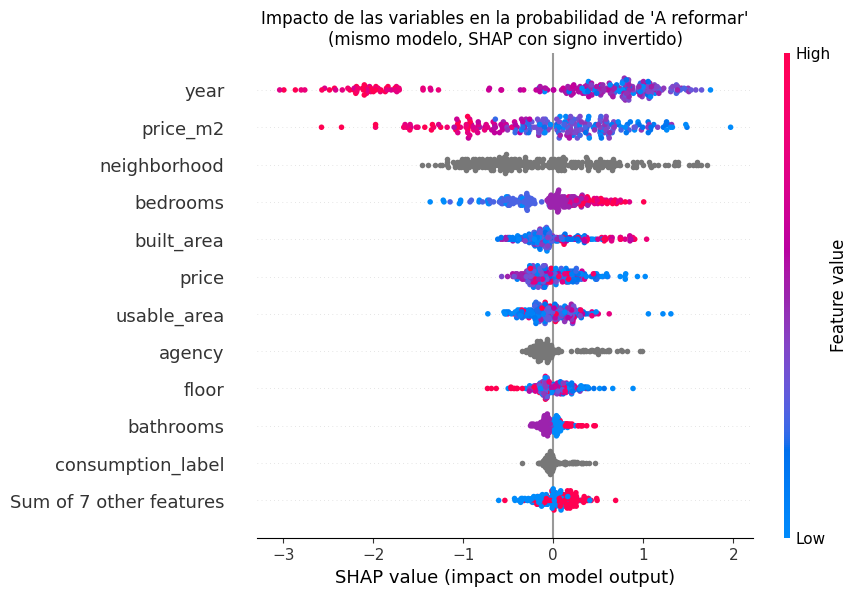

In [111]:
# --- beeswarm para la CLASE POSITIVA: "Buen estado" ---
print("--- SHAP ANALYSIS: BUEN ESTADO (clase positiva) ---")
shap.plots.beeswarm(shap_values, max_display=12, show=False)
plt.title("Impacto de las variables en la probabilidad de 'Buen estado'")
plt.show()

# Crear una versión 'invertida' para interpretar 'A reformar'
shap_values_ar = shap.Explanation(
    values = -shap_values.values,           # cambiamos el signo
    base_values = shap_values.base_values,  # mantenemos el mismo baseline
    data = shap_values.data,                # mismas features originales
    feature_names = shap_values.feature_names
)

print("\n--- SHAP ANALYSIS: A REFORMAR (clase opuesta) ---")
shap.plots.beeswarm(shap_values_ar, max_display=12, show=False)
plt.title("Impacto de las variables en la probabilidad de 'A reformar'\n(mismo modelo, SHAP con signo invertido)")
plt.show()


--- WATERFALL: A REFORMAR (House index 0) ---


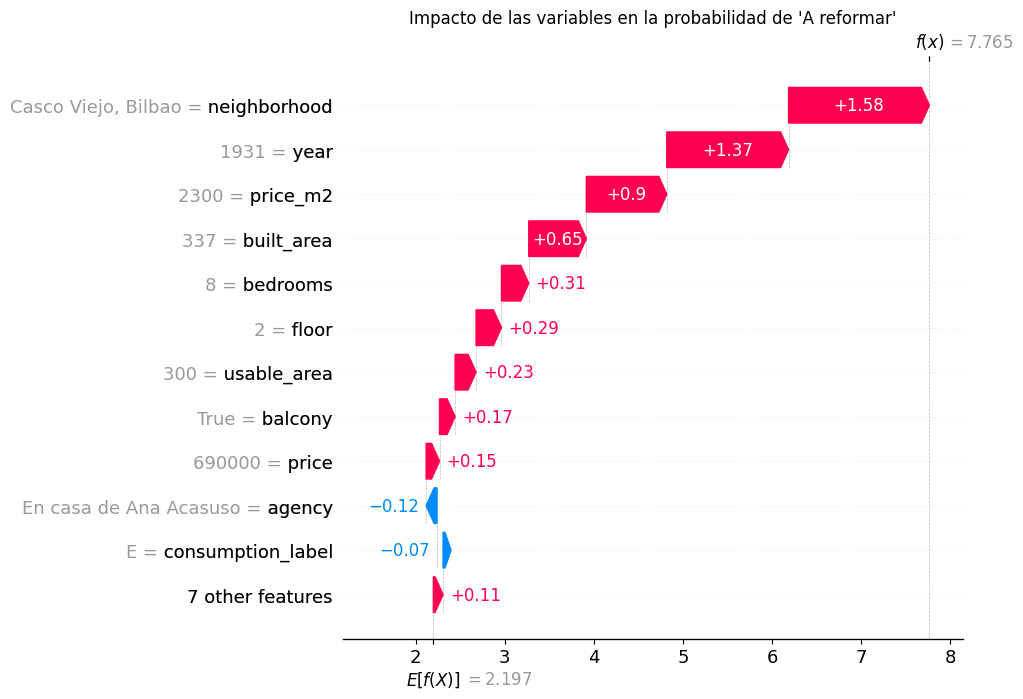


--- WATERFALL: BUEN ESTADO (House index 3) ---


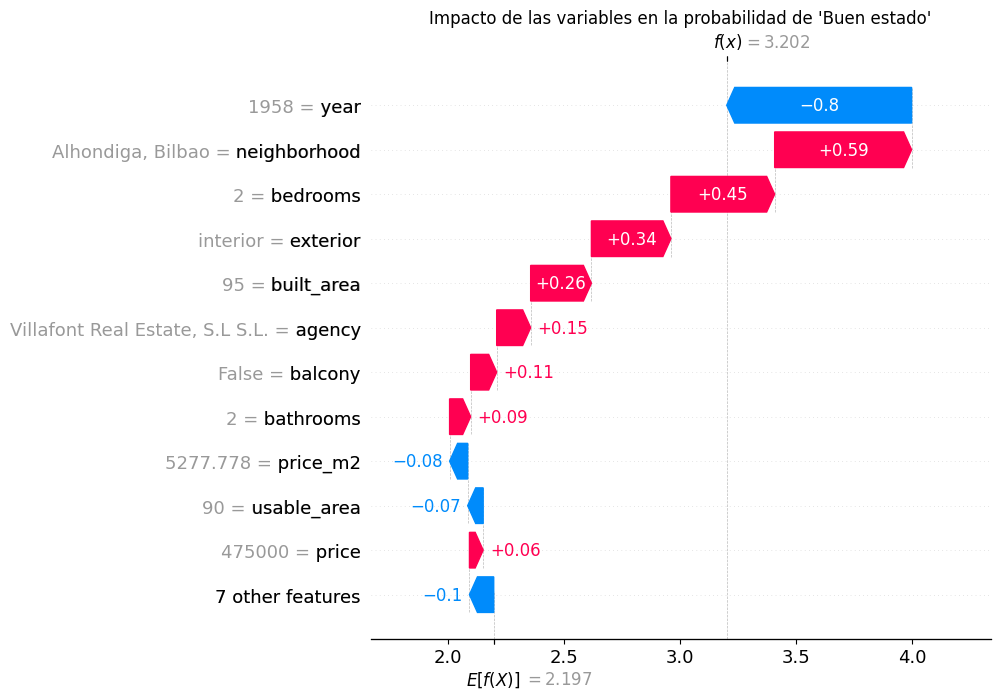

In [112]:
# USE THIS CELL TO COMPARE TWO INSTANCES OF TWO CLASSES DIRECTLY

zona_A = 'A reformar'
zona_B = 'Buen estado'
targets = [zona_A, zona_B]

# y_test_raw es tu vector de etiquetas en texto en el test
y_test_values = y_test_raw.values if hasattr(y_test_raw, "values") else y_test_raw

for nombre_zona in targets:
    # Buscamos una muestra de esa clase en el test
    indices_candidatos = np.where(y_test_values == nombre_zona)[0]

    if len(indices_candidatos) == 0:
        print(f"No hay ejemplos de '{nombre_zona}' en el conjunto de test.")
        continue

    sample_idx = indices_candidatos[0]
    print(f"\n--- WATERFALL: {nombre_zona.upper()} (House index {sample_idx}) ---")

    # Para modelo binario:
    #   - shap_values[sample_idx] -> impacto sobre la clase positiva
    #   - si quieres la clase opuesta, inviertes el signo
    if nombre_zona == 'Buen estado':
        # asumimos que es la clase positiva (la de probabilidad modelada directamente)
        shap_instance = shap_values[sample_idx]
        titulo = "Impacto de las variables en la probabilidad de 'Buen estado'"
    else:
        # 'A reformar' => interpretamos como la clase opuesta
        shap_instance = shap.Explanation(
            values       = -shap_values.values[sample_idx],
            base_values  = shap_values.base_values[sample_idx],
            data         = shap_values.data[sample_idx],
            feature_names= shap_values.feature_names
        )
        titulo = "Impacto de las variables en la probabilidad de 'A reformar'"

    shap.plots.waterfall(shap_instance, max_display=12, show=False)
    plt.title(titulo)
    plt.show()
